### Image Processing Setup for Face Scanning

This section imports essential dependencies for capturing and processing images in this Colab notebook:

- **IPython.display**: Facilitates displaying images, running JavaScript, and rendering HTML within the notebook.
- **google.colab.output**: Allows executing JavaScript and interacting with notebook outputs.
- **base64**: Handles encoding/decoding images, useful for format conversions.
- **cv2 (OpenCV)**: A robust library for image processing and computer vision tasks.
- **numpy**: Provides support for array manipulation, integral to image processing.
- **PIL (Python Imaging Library)**: Used for opening, manipulating, and saving image files.
- **io**: Manages byte streams, crucial for reading and writing images.
- **html**: Safely renders HTML content in the notebook.
- **time**: Handles time-related tasks, such as adding delays or recording timestamps during image processing.

These imports prepare the environment for capturing images via a bounding box camera and analyzing features like brightness, contrast, quality, and face alignment.


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

### Image Conversion Functions

This section defines two essential functions to bridge the gap between JavaScript and OpenCV image processing:

- **`js_to_image(js_reply)`**: Converts a JavaScript object containing an image captured from the webcam into an OpenCV BGR image format.
  - **Parameters**:
    - `js_reply`: JavaScript object containing the image data from the webcam.
  - **Returns**:
    - `img`: The image converted to an OpenCV BGR format, ready for further processing.
  - **Process**:
    1. Decodes the base64-encoded image received from the JavaScript object.
    2. Converts the decoded bytes into a numpy array.
    3. Decodes the numpy array into an OpenCV BGR image.

- **`bbox_to_bytes(bbox_array)`**: Converts an OpenCV image containing a rectangle bounding box into a base64-encoded byte string, which can be overlaid on the video stream.
  - **Parameters**:
    - `bbox_array`: A numpy array representing the pixels of the rectangle to be overlaid.
  - **Returns**:
    - `bytes`: A base64-encoded byte string of the image, formatted as a PNG for overlay purposes.
  - **Process**:
    1. Converts the numpy array into a PIL image in RGBA format.
    2. Saves the PIL image as a PNG in a byte buffer.
    3. Converts the byte buffer to a base64-encoded string suitable for overlaying on the video stream.

These functions facilitate seamless image data exchange between the JavaScript front-end and OpenCV, enabling real-time image processing and video stream overlays.


In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

### Initializing Haar Cascade Face Detection Model

In this section, we initialize the Haar Cascade face detection model using OpenCV. This model is pre-trained to detect faces in images.

- **`face_cascade`**: The variable that stores the Haar Cascade classifier for frontal face detection.
  - **Process**:
    1. **Loading the Cascade Classifier**: The `cv2.CascadeClassifier` function is used to load the pre-trained Haar Cascade model for detecting faces.
    2. **Locating the XML File**: The path to the `haarcascade_frontalface_default.xml` file, which contains the face detection model, is dynamically found using `cv2.samples.findFile`. This ensures that the correct file is loaded regardless of the environment.
  
This classifier will be used in subsequent steps to detect faces within images or video frames, forming the foundation for various face detection and recognition tasks.


In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

### Capture and Process Photo with Face Detection

This section defines the `take_photo` function, which captures an image from the webcam, processes it using OpenCV, and detects faces using the Haar Cascade model.

- **`take_photo(filename='photo.jpg', quality=0.8)`**: Captures a photo from the webcam, detects faces, draws bounding boxes around them, and saves the image.
  - **Parameters**:
    - `filename`: The name of the file where the captured image will be saved (default is 'photo.jpg').
    - `quality`: The quality of the captured image, specified as a value between 0 and 1 (default is 0.8).
  - **Process**:
    1. **JavaScript Setup**: A JavaScript function is executed to access the webcam, display a live video feed, and capture a photo when the "Capture" button is clicked.
    2. **Image Conversion**: The captured image is returned as a base64 string, which is then converted into an OpenCV format image using the `js_to_image` function.
    3. **Grayscale Conversion**: The image is converted to grayscale, which is required for face detection using Haar Cascades.
    4. **Face Detection**: The grayscale image is analyzed using the Haar Cascade model to detect faces, and the bounding box coordinates are obtained.
    5. **Drawing Bounding Boxes**: Bounding boxes are drawn around detected faces in the original image.
    6. **Saving the Image**: The processed image, with bounding boxes, is saved to the specified filename.
  
This function integrates JavaScript and OpenCV to enable real-time face detection directly within the notebook, making it an interactive tool for image capture and processing.


In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

### Capturing and Displaying a Photo with Error Handling

This section demonstrates how to capture a photo using the `take_photo` function, display the captured image, and handle potential errors:

- **Photo Capture**: The `take_photo` function is called with the filename 'photo.jpg' to capture and save the image.
- **Displaying the Image**: After the image is successfully saved, it is displayed within the notebook using the `display` function from IPython.
- **Error Handling**:
  - If an error occurs (e.g., the user does not have a webcam or denies permission to access it), an exception is caught and the error message is printed.
  
This code ensures that the image capture process is robust, gracefully handling situations where webcam access is not available.


In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

### Face Detection and Quality Assessment with RetinaFace

In this section, we integrate face detection with image quality assessment using the RetinaFace model and custom functions for evaluating brightness, contrast, noise, and sharpness:

- **RetinaFace Installation**: Ensure that RetinaFace is installed for accurate face detection.
  ```python
  # Install RetinaFace for face detection
  !pip install retina-face


### Capture Photo, Analyze Quality, and Save with Error Handling

This section demonstrates how to capture a photo from the webcam, analyze its quality using various metrics, and save the image if it meets the quality criteria. It also includes error handling to manage issues with webcam access.

- **Image Quality Metrics**:
  - **`calculate_brightness(img)`**: Computes the average brightness of the image.
  - **`calculate_contrast(img)`**: Measures the contrast of the image by calculating the standard deviation.
  - **`calculate_noise(img)`**: Estimates noise level by computing the variance of the image.
  - **`calculate_sharpness(img)`**: Assesses sharpness using the Laplacian variance of the grayscale image.

- **`take_photo(filename='photo.jpg', quality=2)`**:
  - Captures a photo using the webcam and processes it.
  - **Face Detection**: Utilizes RetinaFace to detect faces in the captured image.
  - **Feature Calculation**: Calculates brightness, contrast, noise, and sharpness for each detected face.
  - **Quality Check**: Applies thresholds for these features to determine if the image quality is acceptable.
  - **Drawing Bounding Boxes**: Draws rectangles around faces in the image if the quality criteria are met.
  - **Saving Image**: Saves the processed image if it meets the quality thresholds.

- **Error Handling**:
  - If an error occurs during photo capture or processing (e.g., due to webcam issues), an exception is caught and the error message is printed.

This code integrates image quality analysis with face detection and captures the image only if it meets the specified quality criteria, ensuring that the saved image is of acceptable quality.


<IPython.core.display.Javascript object>

Brightness: 110.44395477207978, Contrast: 56.35564580613505, Noise: 3175.9588142265475, Sharpness: 325.9860183205918
Image accepted and saved to photo.jpg


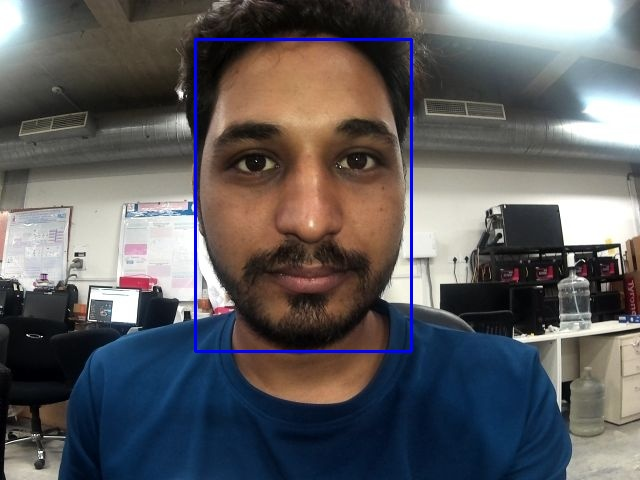

In [ ]:
# # Install RetinaFace for face detection
!pip install retina-face

from retinaface import RetinaFace

# Function to calculate brightness
def calculate_brightness(img):
    return np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:,:,2])

# Function to calculate contrast
def calculate_contrast(img):
    return img.std()

# Function to calculate noise
def calculate_noise(img):
    return np.var(img)

# Function to calculate sharpness using Laplacian
def calculate_sharpness(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def take_photo(filename='photo.jpg', quality=2):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    # Get photo data
    data = eval_js('takePhoto({})'.format(quality))
    # Get OpenCV format image
    img = js_to_image(data)
    # Detect faces using RetinaFace
    faces = RetinaFace.detect_faces(img)

    if isinstance(faces, dict):
        for face_id, face_info in faces.items():
            x1, y1, x2, y2 = face_info['facial_area']
            face_img = img[y1:y2, x1:x2]

            # Calculate features
            brightness = calculate_brightness(face_img)
            contrast = calculate_contrast(face_img)
            noise = calculate_noise(face_img)
            sharpness = calculate_sharpness(face_img)

            print(f'Brightness: {brightness}, Contrast: {contrast}, Noise: {noise}, Sharpness: {sharpness}')

            # Apply thresholds
            if brightness > 90 and contrast < 60 and noise < 1500 and sharpness  <500:
                img = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.imwrite(filename, img)
                print(f'Image accepted and saved to {filename}')
            else:
                print('Image rejected due to low quality features')
                return None

    return filename

try:
    filename = take_photo('photo.jpg')
    if filename:
        display(Image(filename))
except Exception as err:
    print(str(err))


In [ ]:

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes